# Processing input data

- append image to sinogram
- fix dimension issues using 0 padding
- fix multiple of 16 issues using 0 padding

As input data we will append the image to the sinogram. There will be a mismatch in height which we will solve by using 0 padding. 
Due to the convolution layers in the network, it is desired for the input dimensions to be multiples of 16. 


In [5]:
import numpy as np
from libs.simulatepreps import projectMatrix

## Define phantom and generate projection matrix

In [27]:
# generate a bone and water phantom with a 32x32 size
## SETTINGS ##
objectSize = 32                         # Object Size a square
nPixelsY = 64                           # Number of pixels on the detector plate.
nPixelsZ = 44                           # Number of pixels on the detector plate.
pixelPitch = 1                          # Pixel pitch
nPixelsPerProj = nPixelsZ * nPixelsY    # The total number of pixels on the detector plate
projections = 32                        # Number of projections


def generatePhantom(size):
    bone_cylinder = np.full((size, size, size), 0.05, dtype=np.float32)
    water_cylinder = np.full((size, size, size), 0.05, dtype=np.float32)

    radius = 0.3 * size
    center = size // 2

    for x in range(size):
        for y in range(size):
            for z in range(size):
                if ((x - center) ** 2 + (y - center) ** 2)<= radius ** 2:
                    if (z > 2 and z < size - 2):
                        bone_cylinder[x, y, z] = 1.0
                        water_cylinder[x, y, z] = 1.0

    return bone_cylinder, water_cylinder

bone, water = generatePhantom(objectSize)
x = np.column_stack((bone.ravel(), water.ravel()))
y, _, _, _ = projectMatrix(x, objectSize, nPixelsY, nPixelsZ, pixelPitch, projections)


## define prepareInput and prepareOutput

In [28]:
def prepareInput(y):
    
    # Curriculum learning input preparation function
    # As an input: 10 channels consisting of empty images next to the sinograms

    # shape: 32x48x96, beginning with a 32x32x32 zero image with padding and a 32x44x64 image with padding

    zeroImage = np.zeros((objectSize, objectSize + 16, objectSize))
    zeroBin = np.zeros((projections, 2, nPixelsY))
    
    inputs = []

    # we have one dataset per y! with 10 channels (one for bone and one for water)
    for i, bins in enumerate(y):
        # no that is not correct
        
        # input is 10 channels, zeroimage appended to the energy bin
        bin = bins.reshape((projections, nPixelsZ, nPixelsY))
        
        # normalize so biggest value is 1, smalles value is 0
        bin = (bin - np.min(bin)) / (np.max(bin) - np.min(bin))
        
        bin = np.concatenate((zeroBin, bin, zeroBin), axis=1)
        # for input image, concatinate bin to zeroImage in x direction
        input_image = np.concatenate((zeroImage, bin), axis=2)
        inputs.append(input_image)
        inputs.append(input_image)
    
    return inputs

def prepareOutput(water, bone):

    water = np.flip(water, axis=1)  # flip along z-axis
    water = np.flip(water, axis=2)  # flip along y-axis
    bone = np.flip(bone, axis=1)    # flip along z-axis
    bone = np.flip(bone, axis=2)    # flip along y-axis
    
    zeroImage = np.zeros((32, 8, 32))
    zeroBin = np.zeros((projections, nPixelsZ + 4, nPixelsY))  # zero bin for the energy bin
    outputs = []
    
    bone_output = np.concatenate((zeroImage, bone, zeroImage), axis=1)
    water_output = np.concatenate((zeroImage, water, zeroImage), axis=1)

    bone_output = np.concatenate((bone_output, zeroBin), axis=2)
    water_output = np.concatenate((water_output, zeroBin), axis=2)
    
    outputs = [bone_output, water_output]  # shape will be (10, 32, 44, 64)
    
    return outputs

# Prepare the input and output data
input = prepareInput(y)
output = prepareOutput(water, bone)


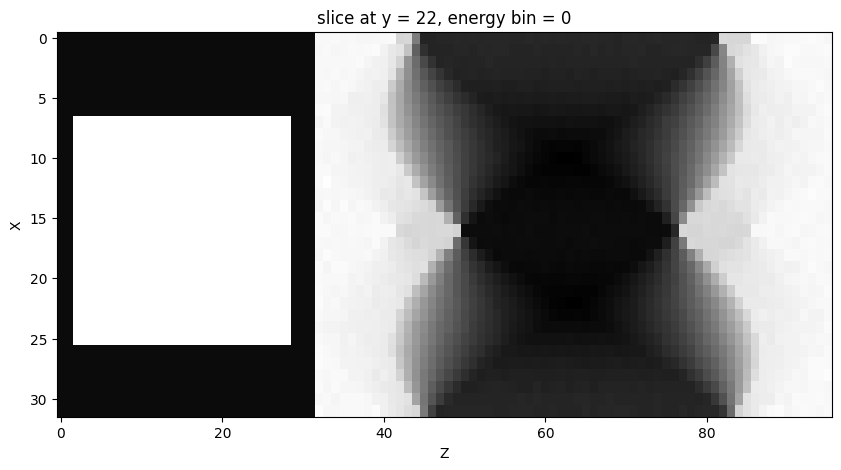

In [44]:
#| label: input_data

from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

energy_bin = 0

#invert the matrix, so z = 0 becomes z = max and y = 0 becomes y = max
flipped_bone_square = np.flip(bone, axis=1)  # flip along z-axis
flipped_bone_square = np.flip(flipped_bone_square, axis=2)  # flip along z-axis


#in input_square[0], replace [:, 8:40, :32] with the phantom
input[energy_bin][:, 8:40, :32] = flipped_bone_square[:, :, :]

# visualize with a slider, put slider for y value

plt.figure(figsize=(10, 5))
plt.imshow(input[energy_bin][:, 22, :], cmap='gray', aspect='auto')
plt.title(f'slice at y = 22, energy bin = {energy_bin}')
plt.xlabel('Z')
plt.ylabel('X')

# draw red rectangle around bottom and top padding
# draw red red rectangle from (0, 0) to (32, 8) and (0, 40) to (32, 48)
plt.show()
